In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
import re
import matplotlib.pyplot as plt

### Load the excluded ingredients and two metadata files. Concatenate the metadata files into one. 

In [2]:
# Read the list of excluded ingredients
with open('excluded_ingredients.txt', 'r') as f:
    excluded_ingredients = set(line.strip() for line in f)

# Function to read metadata CSV files without headers and assign column names
def read_metadata(csv_file):
    # Read without headers
    metadata = pd.read_csv(csv_file, header=None, low_memory=False)
    num_cols = metadata.shape[1]
    
    # Define base columns and ingredient columns
    base_columns = ['dish_id', 'total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein']
    ingredient_columns = ['ingr_{n}_id', 'ingr_{n}_name', 'ingr_{n}_grams', 'ingr_{n}_calories', 'ingr_{n}_fat', 'ingr_{n}_carb', 'ingr_{n}_protein']
    
    len_base = len(base_columns)
    len_ingr = len(ingredient_columns)
    max_n = (num_cols - len_base) // len_ingr
    
    # Generate column names
    columns = base_columns.copy()
    for n in range(1, max_n + 1):
        columns += [col.format(n=n) for col in ingredient_columns]
    
    # Check if total columns match
    if len(columns) != num_cols:
        print(f"Warning: Number of columns does not match for {csv_file}")
        # Optionally, handle or raise an error here
    
    metadata.columns = columns
    return metadata

# Read the metadata CSV files
metadata_cafe1 = read_metadata('nutrition5k_dataset/metadata/dish_metadata_cafe1.csv')
metadata_cafe2 = read_metadata('nutrition5k_dataset/metadata/dish_metadata_cafe2.csv')

# Concatenate the dataframes
metadata = pd.concat([metadata_cafe1, metadata_cafe2], ignore_index=True)

### Create a sorted list of ingredients. Make sure that excluded ingredients are not in the list. (Some ingredients are excluded to overcome class imbalance and because the model is not likely to detect them, e.g. salt, pepper, wine, etc.)

In [3]:
# Extract ingredient indices from the column names
ingredient_indices = set()
for col in metadata.columns:
    m = re.match(r'ingr_(\d+)_name', col)
    if m:
        ingredient_indices.add(int(m.group(1)))
ingredient_indices = sorted(list(ingredient_indices))

# Construct a mapping from dish_id to ingredients (excluding excluded ingredients)
dish_ingredients = {}

for idx, row in metadata.iterrows():
    dish_id = row['dish_id']
    ingredients = []
    for n in ingredient_indices:
        ingr_name_col = f'ingr_{n}_name'
        if ingr_name_col in row and not pd.isna(row[ingr_name_col]):
            ingredient_name = str(row[ingr_name_col]).strip()
            if ingredient_name not in excluded_ingredients:
                ingredient = {
                    'name': ingredient_name,
                    'grams': row.get(f'ingr_{n}_grams', np.nan),
                    'calories': row.get(f'ingr_{n}_calories', np.nan),
                    'fat': row.get(f'ingr_{n}_fat', np.nan),
                    'carb': row.get(f'ingr_{n}_carb', np.nan),
                    'protein': row.get(f'ingr_{n}_protein', np.nan)
                }
                ingredients.append(ingredient)
    dish_ingredients[dish_id] = ingredients

# Create a list of all unique ingredients
all_ingredients_set = set()
for ingredients in dish_ingredients.values():
    for ingredient in ingredients:
        all_ingredients_set.add(ingredient['name'])

all_ingredients = sorted(list(all_ingredients_set))
ingredient_to_index = {ingredient: idx for idx, ingredient in enumerate(all_ingredients)}

### Only use metadata rows for which there is an image in the imagery/realsense_overhead folder.

In [4]:
# Prepare the dataset with image paths and labels
data = []

count=0
for dish_id, ingredients in dish_ingredients.items():
    image_path = f'nutrition5k_dataset/imagery/realsense_overhead/{dish_id}/rgb.png'
    if os.path.exists(image_path):
        # Create the multi-hot label vector
        label = np.zeros(len(all_ingredients), dtype=np.float32)
        for ingredient in ingredients:
            idx = ingredient_to_index[ingredient['name']]
            label[idx] = 1.0
        data.append({
            'dish_id': dish_id,
            'image_path': image_path,
            'label': label
        })
    else:
        count += 1
        # print(f'Warning: Image for {dish_id} not found at {image_path}')
        print(f"There are {count} dish_id that have no image at nutrition5k_dataset/imagery/realsense_overhead.", end="\r")

### Display two examples of binarized ingredients data.

In [5]:
data[:2]

[{'dish_id': 'dish_1561662216',
  'image_path': 'nutrition5k_dataset/imagery/realsense_overhead/dish_1561662216/rgb.png',
  'label': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0

### Define training and validation datasets.

In [6]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Prepare lists of image paths and labels
train_image_paths = [item['image_path'] for item in train_data]
train_labels = [item['label'] for item in train_data]

val_image_paths = [item['image_path'] for item in val_data]
val_labels = [item['label'] for item in val_data]

### Preprocess the images for MobileNetV3.  Create the training and validation datasets.

In [7]:
# Load and preprocess images
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    return image, label

# Create TensorFlow datasets
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Create a custom F1-score for this model
<p>tf.keras doesn't provide an F1 score suitable for multiclass classification, and can't be used in the model.compile function. The F1 score should be computed over the entire dataset, but just per batch, which tf.keras does. Therefore this code calculates the F1 score at the end of each epoch over the entire validation dataset, loading it into memory before training and comparing the predictions with all the true labels.</p> 

In [13]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import Metric

def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image.numpy()

# Validation dataset pointer has to be reset to the beginning. Load images into NumPy arrays once again. 
val_x = np.array([load_and_preprocess_image(path) for path in val_image_paths])
val_y = np.array(val_labels)     # Ensure val_labels is a NumPy array, too.


class F1Score(Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision = tf.keras.metrics.Precision(thresholds=self.threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=self.threshold)
        self.f1 = self.add_weight(name='f1', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update precision and recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

        # Compute F1 score
        precision = self.precision.result()
        recall = self.recall.result()

        f1 = tf.cond(
            tf.math.logical_and(tf.math.not_equal(precision + recall, 0), tf.math.not_equal(precision, 0)),
            lambda: 2 * ((precision * recall) / (precision + recall)),
            lambda: tf.cast(0.0, tf.float32)
        )

        self.f1.assign(f1)

    def result(self):
        return self.f1

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1.assign(0.0)

### Define the model, based on MobileNetV3Large. Set freezing layer for transfer learning. Define custom layers. Compile the model. Visualize total layers. 

In [14]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from sklearn.metrics import f1_score

# Load the pre-trained MobileNetV3 model without the top layers
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Specify freezing layer
for layer in base_model.layers[:90]:
    layer.trainable = False
for layer in base_model.layers[90:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(all_ingredients), activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        BinaryAccuracy(name='binary_accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc', multi_label=True),
        F1Score(name='f1_score')
    ]
)

print(f"Model has {len(model.layers)} layers, of which {len(base_model.layers)} come from MobileNetV3")

Model has 189 layers, of which 187 come from MobileNetV3


### Set epoch number and start training the model.

In [15]:
# Instantiate the callback
#f1_callback = F1ScoreCallback(val_x, val_y)
epochs = 20

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 331ms/step - auc: 0.4493 - binary_accuracy: 0.7535 - f1_score: 0.0464 - loss: 0.4942 - precision: 0.0263 - recall: 0.2533 - val_auc: 0.4362 - val_binary_accuracy: 0.9780 - val_f1_score: 0.0077 - val_loss: 0.0976 - val_precision: 0.5385 - val_recall: 0.0039
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 331ms/step - auc: 0.5493 - binary_accuracy: 0.9762 - f1_score: 0.0501 - loss: 0.0901 - precision: 0.7242 - recall: 0.0260 - val_auc: 0.4748 - val_binary_accuracy: 0.9780 - val_f1_score: 0.0033 - val_loss: 0.0888 - val_precision: 0.6667 - val_recall: 0.0017
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 335ms/step - auc: 0.6378 - binary_accuracy: 0.9770 - f1_score: 0.1078 - loss: 0.0776 - precision: 0.7199 - recall: 0.0583 - val_auc: 0.5244 - val_binary_accuracy: 0.9781 - val_f1_score: 0.0111 - val_loss: 0.0856 - val_precision: 0.9091 - val_recall: 0.0056
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 343ms/step - auc: 0.6816 - binary_accuracy: 0.9777 - f1_score

### Plot loss, accuracy, AUC and F1 score

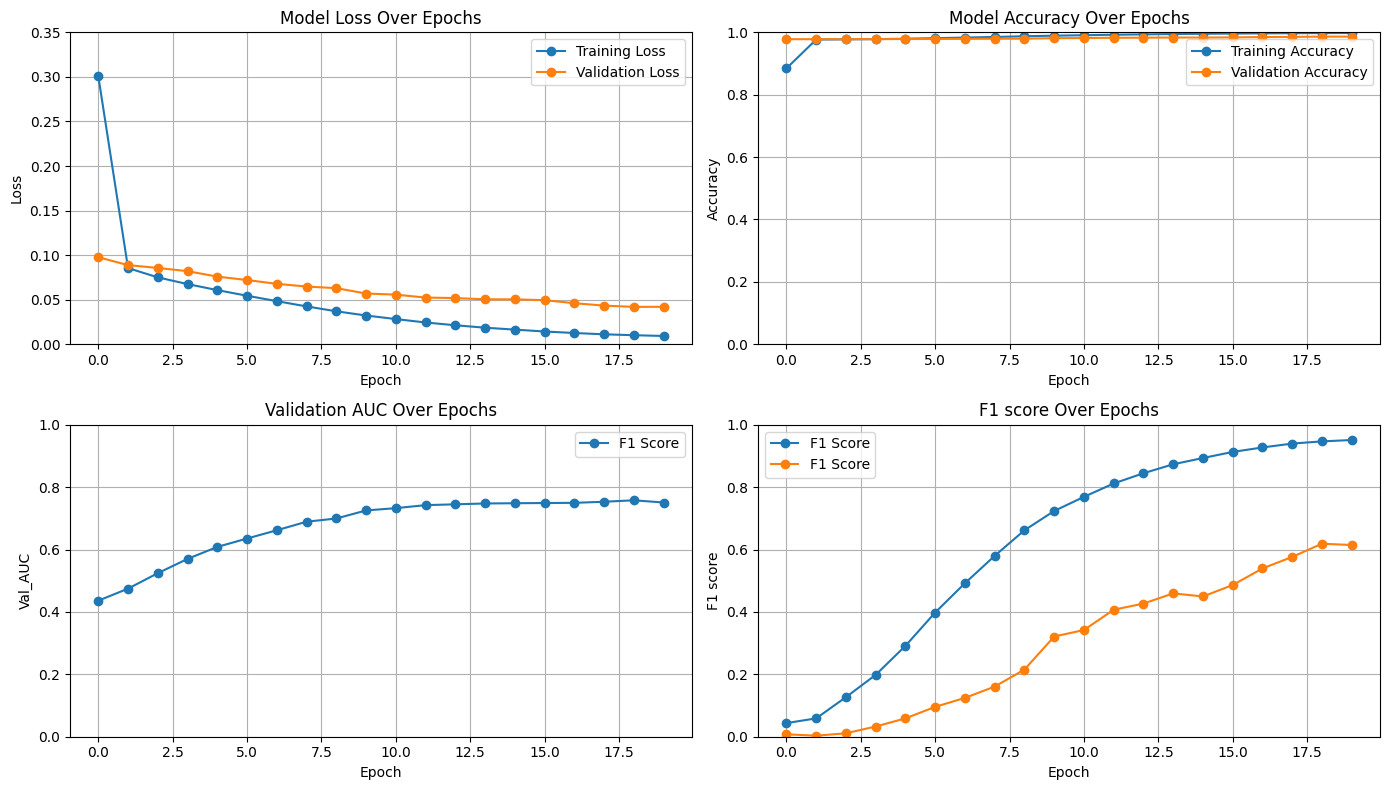

In [23]:
# Plot training & validation loss values
plt.figure(figsize=(14, 8))

# Plot Loss
plt.subplot(2, 2, 1)
plt.ylim(0,0.35)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.ylim(0,1)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC Plot
plt.subplot(2, 2, 3)
plt.ylim(0,1)
plt.plot(history.history['val_auc'], label='F1 Score', marker='o')
plt.title('Validation AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Val_AUC')
plt.legend()
plt.grid(True)

# F1 Score Plot
plt.subplot(2, 2, 4)
plt.ylim(0,1)
plt.plot(history.history['f1_score'], label='F1 Score', marker='o')
plt.plot(history.history['val_f1_score'], label='F1 Score', marker='o')
plt.title('F1 score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Calculate Hamming Score

In [27]:
from sklearn.metrics import hamming_loss

# Need to reset the validation dataset pointer to the beginning. That requires re-running the validation set definitions. 
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image.numpy()  # Convert to NumPy array

# Load validation images into NumPy arrays
val_x = np.array([load_and_preprocess_image(path) for path in val_image_paths])

# Convert labels to NumPy arrays
val_y = np.array(val_labels)

# Now, we can collect predictions on the validation data
y_pred_probs = model.predict(val_x)
y_pred = (y_pred_probs >= 0.5).astype(int)
y_true = val_y

# Compute Hamming Score
hamming = hamming_loss(y_true, y_pred_binary)
hamming_score = 1 - hamming
print(f"Validation Hamming Score: {hamming_score:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step
Validation Hamming Score: 0.9862


### Make predictions. Adjust prediction threshold value as needed. 

In [28]:
threshold = 0.3   # Adjust as necessary

def predict_ingredients(model, image_path, ingredient_to_index, threshold=threshold):
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    image = tf.expand_dims(image, 0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(image)[0]

    # Get predicted ingredients based on the threshold
    predicted_indices = [i for i, p in enumerate(predictions) if p >= threshold]
    index_to_ingredient = {idx: ingr for ingr, idx in ingredient_to_index.items()}
    predicted_ingredients = [index_to_ingredient[idx] for idx in predicted_indices]
    return predicted_ingredients

# Function to calculate total nutritional information
def calculate_nutrition(predicted_ingredients, ingredient_data):
    total_nutrition = {
        'grams': 0.0,
        'calories': 0.0,
        'fat': 0.0,
        'carb': 0.0,
        'protein': 0.0
    }
    for ingr_name in predicted_ingredients:
        # Find the ingredient data from the metadata
        for dish_id, ingredients in dish_ingredients.items():
            for ingredient in ingredients:
                if ingredient['name'] == ingr_name:
                    total_nutrition['grams'] += ingredient['grams']
                    total_nutrition['calories'] += ingredient['calories']
                    total_nutrition['fat'] += ingredient['fat']
                    total_nutrition['carb'] += ingredient['carb']
                    total_nutrition['protein'] += ingredient['protein']
                    break  # Assuming ingredient names are unique
    return total_nutrition

# Example usage
test_image_path = val_image_paths[1]
predicted_ingredients = predict_ingredients(model, test_image_path, ingredient_to_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


### Predict on the test set.  Use the dropdown selector to select a dish. 

In [29]:
from IPython.display import display, Image, clear_output
import ipywidgets as widgets

# Create a mapping of dish_id to image_path in the validation set
val_dish_ids = [item['dish_id'] for item in val_data]
val_image_paths = [item['image_path'] for item in val_data]
dish_id_to_image_path = dict(zip(val_dish_ids, val_image_paths))

# Create the dropdown widget with dish_ids
dropdown = widgets.Dropdown(
    options=val_dish_ids,
    description='Dish ID:',
    disabled=False,
)

# Create an Output widget to capture and display outputs
output = widgets.Output()

# Define the event handler for the dropdown widget
def on_dropdown_change(change):
    # Check if the change is in the value of the dropdown
    if change['name'] == 'value' and change['new'] is not None:
        dish_id = change['new']
        image_path = dish_id_to_image_path[dish_id]
        with output:
            output.clear_output(wait=True)  # Clear previous output
            print(f"Dish ID: {dish_id}")
            
            # Display the dish image
            display(Image(filename=image_path))
            
            # Predict ingredients
            predicted_ingredients = predict_ingredients(model, image_path, ingredient_to_index)
            print(f"\nPredicted ingredients:\n{predicted_ingredients}")
            
            # Calculate nutritional information
            total_nutrition = calculate_nutrition(predicted_ingredients, dish_ingredients)
            print("\nTotal nutritional information:")
            print(total_nutrition)
            
# Attach the event handler to the dropdown widget
dropdown.observe(on_dropdown_change, names='value')

# Display the dropdown widget and output together using VBox
ui = widgets.VBox([dropdown, output])
display(ui)

# Manually trigger the handler to display initial information
if dropdown.value is not None:
    on_dropdown_change({'name': 'value', 'new': dropdown.value})